In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import re

In [0]:
print(pd.__version__)
data = pd.read_csv("/content/drive/My Drive/DA_Project/train.csv")
t_data = pd.read_csv("/content/drive/My Drive/DA_Project/test.csv")
print(data.shape)
print(t_data.shape)
#print(data)
#print(data.columns)
data = data.append(t_data, ignore_index = True)
data

1.0.3
(27486, 4)
(3535, 3)


,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive
...,...,...,...,...
31016,2f8444db6c,@_shannon1234 Shannie im so sorry! didnt mean ...,NaN,negative
31017,11de8c0456,Im Slowing on My Tweets..Cuase I Lost My Phone,NaN,negative
31018,08f6036add,"Invasion of the Old Ladies has just ended, sti...",NaN,neutral
31019,27d6472b81,$#@! My nose stud fell out and I can't find it...,NaN,negative


In [0]:
def getLower(x):
  #print(x)
  if pd.isna(x):
    return ''
  return x.lower()

data = data.astype('string')
data['sentiment'] = data['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
data['text'] = data['text'].map(getLower)
data['text'] = data['text'].str.replace('[^\w\s]', '')
data

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,spent the entire morning in a meeting w a vend...,my boss was not happy w/ them. Lots of fun.,0
1,251b6a6766,oh good idea about putting them on ice cream,Good,1
2,c9e8d1ef1c,says good or should i say bad afternoon httpp...,says good (or should i say bad?) afternoon!,0
3,f14f087215,i dont think you can vote anymore i tried,i dont think you can vote anymore!,-1
4,bf7473b12d,haha better drunken tweeting you mean,better,1
...,...,...,...,...
31016,2f8444db6c,_shannon1234 shannie im so sorry didnt mean to...,<NA>,-1
31017,11de8c0456,im slowing on my tweetscuase i lost my phone,<NA>,-1
31018,08f6036add,invasion of the old ladies has just ended stil...,<NA>,0
31019,27d6472b81,my nose stud fell out and i cant find it loo...,<NA>,-1


In [0]:
print(data.shape)
total_data = data.copy()
data = total_data.iloc[:27486, : ]
t_data = total_data.iloc[27486:,: ]
print(data.shape)
print(t_data.shape)
df_0 = data[data['sentiment'] == -1].sample(frac=1)
df_1 = data[data['sentiment'] == 0].sample(frac=1)
df_2 = data[data['sentiment'] == 1].sample(frac=1)

# we want a balanced set for training against
sample_size = min(len(df_0), len(df_1), len(df_2))
data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size)]).sample(frac=1)
data

(31021, 4)
(27486, 4)
(3535, 4)


,textID,text,selected_text,sentiment
23136,1211606305,if a cong govt was ruling karnataka cauvery w...,"Truly, our politicians have no integrity.",-1
12202,8d31b4cc44,i am sorry,I am sorry.,-1
4219,3d53aa06a2,u callin me grimmy,grimmy,-1
21398,e78dbb2c35,wish i coulda been there,wish,1
22373,49fdfc3d3b,agrees,/agrees,0
...,...,...,...,...
14999,c6d89eb41b,happy mothers day breakfast with the fam lt33,Happy,1
27469,8080dbb71a,save mei feel like im going crazy httpblipfm...,i feel like i'm going crazy.,-1
17957,5c452788b2,the fam back on the big island said the vog ha...,bad,-1
17755,747c796ad4,feel sick too much cheese on toast,sick.,-1


In [0]:
data['l'] = data['text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 13.833932699717442
max length of sentence: 38
std dev length of sentence: 7.127914107327437


In [0]:
sequence_length = 50
max_features = 20000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(data['text'].values)
tokenizer.fit_on_texts(t_data['text'].values)

# this takes our sentences and replaces each word with an integer
X_train = tokenizer.texts_to_sequences(data['text'].values)
X_test = tokenizer.texts_to_sequences(t_data['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X_train = pad_sequences(X_train, sequence_length)
X_test = pad_sequences(X_test, sequence_length)

y_train = pd.get_dummies(data['sentiment']).values
y_test = pd.get_dummies(t_data['sentiment']).values
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3535)


(23358, 50)
(23358, 3)
(3535, 50)
(3535, 3)


In [0]:
import os
embeddings_index = {}
f = open(os.path.join('/content/drive/My Drive/DA_Project/glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


In [0]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29652 unique tokens.


In [0]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

20001


In [0]:
def model():
  model = Sequential()
  model.add(Embedding(num_words,
                      embedding_dim,
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=sequence_length,
                      trainable=True))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.25))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  print(model.summary())
  return model
model = model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2000100   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 2,125,991
Trainable params: 2,125,991
Non-trainable params: 0
____________________________________________

In [0]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 21022 samples, validate on 2336 samples
Epoch 1/5
21022/21022 [==============================] - 84s 4ms/step - loss: 0.8704 - accuracy: 0.5934 - val_loss: 0.7122 - val_accuracy: 0.6794
Epoch 2/5
21022/21022 [==============================] - 82s 4ms/step - loss: 0.7032 - accuracy: 0.6960 - val_loss: 0.6543 - val_accuracy: 0.7222
Epoch 3/5
21022/21022 [==============================] - 79s 4ms/step - loss: 0.6286 - accuracy: 0.7375 - val_loss: 0.6536 - val_accuracy: 0.7303
Epoch 4/5
21022/21022 [==============================] - 82s 4ms/step - loss: 0.5741 - accuracy: 0.7633 - val_loss: 0.6295 - val_accuracy: 0.7380
Epoch 5/5
21022/21022 [==============================] - 80s 4ms/step - loss: 0.5304 - accuracy: 0.7867 - val_loss: 0.6373 - val_accuracy: 0.7427


In [0]:
model.save('/content/drive/My Drive/DA_Project/Bi-LSTM4.h5')
#from keras.models import load_model 
#model = load_model('/content/drive/My Drive/DA_Project/Bi-LSTM3.h5')

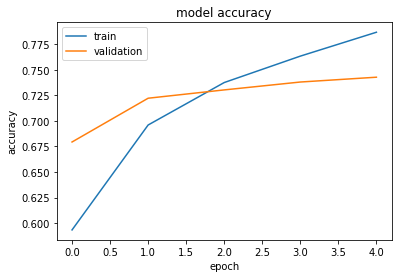

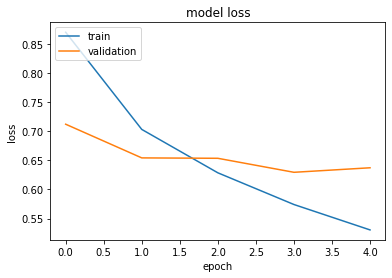

In [0]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [0]:
from operator import eq
y_hat = model.predict(X_test)
predicted = to_categorical(list(map(lambda x: np.argmax(x), y_hat)))
not1hot_predicted = list(map(lambda x: np.argmax(x), predicted))
not1hot_y_test = list(map(lambda x: np.argmax(x), y_test))
print(not1hot_y_test)
print(not1hot_predicted)
#print(not1hot_predicted.size)
#print(not1hot_y_test.size)
total = len(not1hot_y_test)
accuracy = sum(map(eq, not1hot_predicted, not1hot_y_test))/total
print(accuracy)
#accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

[2, 2, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 2, 0, 1, 1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 2, 1, 2, 1, 2, 0, 0, 1, 0, 2, 0, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0, 1, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 0, 

In [0]:
not1hot_predicted = list(map(lambda x: np.argmax(x), predicted))
not1hot_y_test = list(map(lambda x: np.argmax(x), y_test))
conf = confusion_matrix(not1hot_y_test, not1hot_predicted)
conf

array([[ 737,  245,   19],
       [ 227, 1050,  153],
       [  44,  228,  832]])

In [0]:
from sklearn.metrics import f1_score

print(f1_score(not1hot_y_test, not1hot_predicted, average='micro'))
print(f1_score(not1hot_y_test, not1hot_predicted, average='macro'))
print(f1_score(not1hot_y_test, not1hot_predicted, average='weighted'))

0.7408769448373409
0.7447377945866435
0.7419611541946355


In [0]:
from sklearn.metrics import jaccard_score

print(jaccard_score(not1hot_y_test, not1hot_predicted, average='micro'))
print(jaccard_score(not1hot_y_test, not1hot_predicted, average='macro'))
print(jaccard_score(not1hot_y_test, not1hot_predicted, average='weighted'))


0.5884070995281959
0.594400170542701
0.5909048908232024
